# Week 12 Day 1: Requested topic: Fitting

## Objectives:
* Cover performance and syntax for general unbinned fitting.

Remember to `pip install probfit` (`--user` if you are not in a virtual environment). `cupy` is used at the end; you'll need `conda install cupy` in an environment. Times are from a 24 core Xeon with a Titan V.

## Make data

First, we make our data. It's a simple double gaussian with no background.

In [1]:
import probfit
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit

In [2]:
dist = np.hstack([
    np.random.normal(loc=1, scale=2., size=500_000),
    np.random.normal(loc=1, scale=.5, size=500_000)
])

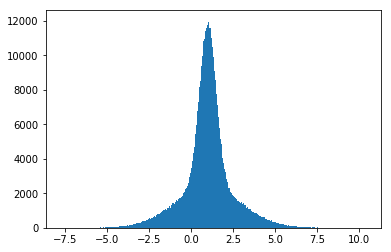

In [3]:
plt.hist(dist, bins='auto');

## Probfit

Now, let's try using probfit to fit the data. First, we have to rename the parameters - probfit merges similar named parameters. I already know that gaussian comes with `x`, `mean`, and `sigma`. We use `AddPdfNorm` to add the pdfs, and they are kept normalized. A new parameter is added, `f_0`.

In [4]:
second_gaussian = probfit.rename(probfit.gaussian, ["x", "mean", "sigma2"])
pdf_function = probfit.AddPdfNorm(probfit.gaussian, second_gaussian)

Now, let's build an unbinned likelyhood function:

In [5]:
unbinned_lh = probfit.UnbinnedLH(pdf_function, dist)

We have to use iMinuit's name based parameter setting interface:

In [6]:
minuit = Minuit(unbinned_lh,
                
                f_0=.5,
                error_f_0=.01,
                limit_f_0=(0,1),
                
                mean=1.5,
                error_mean=.01,
                limit_mean=(-10,10),
                
                sigma=.4,
                limit_sigma=(0,1),
                error_sigma=.01,

                sigma2=3.,
                error_sigma2=.01,
                limit_sigma2=(1,3),
               )

And let's do the fit!

In [7]:
%%time
output = minuit.migrad()

FCN = 1672890.2007343248 
 TOTAL NCALL = 136 
 NCALLS = 136 
 
 
 EDM = 1.993630744763221e-05 
 GOAL EDM = 5e-06 
 
 UP = 0.5 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,mean,0.999509,0.00088523,,,-10,10,No
1,sigma,0.49869,0.0010406,,,0,1,No
2,sigma2,2.00066,0.00256911,,,1,3,No
3,f_0,0.499251,0.00107464,,,0,1,No


CPU times: user 2min 26s, sys: 536 ms, total: 2min 26s
Wall time: 2min 25s


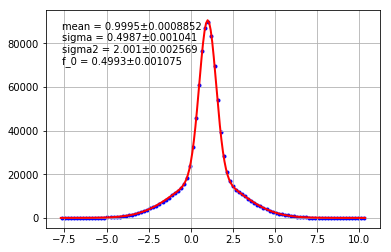

In [8]:
unbinned_lh.draw(minuit);

## GooFit

Let's try that in GooFit. We set up our model in what I view as a more readable but more verbose way:

In [9]:
import goofit

In [10]:
goofit.GOOFIT_DEVICE

'CUDA'

In [11]:
x = goofit.Observable('x', -10, 10)

ds = goofit.UnbinnedDataSet(x)
ds.from_matrix([dist], filter=True)

mean = goofit.Variable('mean', 1.5, -10, 10)
sigma = goofit.Variable('sigma', .4, 0, 1)
sigma2 = goofit.Variable('sigma2', 3, 1, 3)
f_0 = goofit.Variable('f_0', .5, 0, 1)

gauss1 = goofit.GaussianPdf("gauss1", x, mean, sigma)
gauss2 = goofit.GaussianPdf("gauss2", x, mean, sigma2)

pdf = goofit.AddPdf('pdf', [f_0], [gauss1, gauss2])

pdf.fitTo(ds);

MnSeedGenerator: for initial parameters FCN = 3874360.560675
MnSeedGenerator: Initial state:   - FCN =   3874360.560675 Edm =       745589 NCalls =     19
MnSeedGenerator: Negative G2 found - new state:   - FCN =   3734927.892617 Edm =       712880 NCalls =     44
VariableMetric: start iterating until Edm is < 0.0001
VariableMetric: Initial state   - FCN =   3734927.892617 Edm =       712880 NCalls =     44
VariableMetric: Iteration #   0 - FCN =   3734927.892617 Edm =       712880 NCalls =     44
VariableMetric: Iteration #   1 - FCN =   3365453.017804 Edm =      20422.6 NCalls =     56
VariableMetric: Iteration #   2 - FCN =   3351148.936792 Edm =      3752.03 NCalls =     66
VariableMetric: Iteration #   3 - FCN =   3346059.642731 Edm =      286.477 NCalls =     76
VariableMetric: Iteration #   4 - FCN =   3345814.977454 Edm =      22.1674 NCalls =     86
VariableMetric: Iteration #   5 - FCN =   3345732.185534 Edm =       3.5285 NCalls =     96
VariableMetric: Iteration #   6 - FCN

> Note: On a single thread CPU build, this is about 7-10x faster than probfit. This is on a Titan V GPU, so it's a lot more than that.

Plotting is a bit more verbose, but not too bad:

In [12]:
grid, points = pdf.evaluatePdf(x)
xs = grid.to_matrix().flatten()

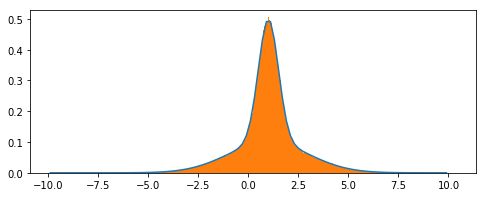

In [13]:
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(xs, points)
ax.hist(dist, bins='auto', density=True)
plt.show()

## Numpy

Let's try this with Numpy and iMinuit. We could use probfit to make the NLL, but it's much faster to do it ourselves.

#### Note:
I originally used numba here, but since this is all done in array form, even parallel Numba is only a small fraction (10-30%) faster on my laptop. On a 24 core Xeon, however... You'll see.

In [14]:
def gaussian(x, μ, σ):
    return 1/np.sqrt(2*np.pi*σ**2) * np.exp(-(x-μ)**2/(2*σ**2))

In [15]:
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

In [16]:
def nll(f_0, mean, sigma, sigma2):
    return -np.sum(np.log(add(dist, f_0, mean, sigma, sigma2)))

In [17]:
nll(.5,.5,.5,.5)

4984868.052020328

In [18]:
%%timeit
nll(.5,.5,.5,.5)

9.65 ms ± 72.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
minuit = Minuit(nll,

                f_0=.5,
                error_f_0=.01,
                limit_f_0=(0,1),
                
                mean=1.5,
                error_mean=.01,
                limit_mean=(-10,10),
                
                sigma=.4,
                limit_sigma=(0,1),
                error_sigma=.01,

                sigma2=3.,
                error_sigma2=.01,
                limit_sigma2=(1,3),
               )

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.


I'm not sure where that errordef warning is coming from.

In [20]:
%%time
output = minuit.migrad()

FCN = 1672890.2007173877 
 TOTAL NCALL = 137 
 NCALLS = 137 
 
 
 EDM = 3.0558511824313418e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,f_0,0.499254,0.00151977,,,0,1,No
1,mean,0.999506,0.0012519,,,-10,10,No
2,sigma,0.498688,0.00147162,,,0,1,No
3,sigma2,2.00066,0.00363329,,,1,3,No


CPU times: user 44.1 s, sys: 1.72 s, total: 45.9 s
Wall time: 1.91 s


In [21]:
# Much (2-3x) slower if we use this in Minuit
unbinned_lh = probfit.UnbinnedLH(add, dist)

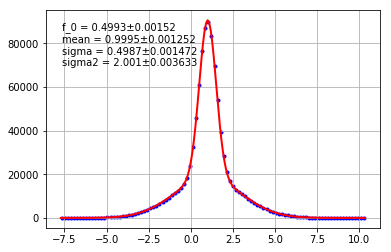

In [22]:
unbinned_lh.draw(minuit);

## Numba

Let's use Numba's parallel abilities:

In [23]:
import numba

@numba.njit(parallel=True)
def gaussian(x, μ, σ):
    return 1/np.sqrt(2*np.pi*σ**2) * np.exp(-(x-μ)**2/(2*σ**2))

In [24]:
@numba.njit(parallel=True)
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

In [25]:
@numba.njit(parallel=True)
def nll(f_0, mean, sigma, sigma2):
    return -np.sum(np.log(add(dist, f_0, mean, sigma, sigma2)))

In [26]:
nll(.5,.5,.5,.5)

4984868.0520203225

In [27]:
%%timeit
nll(.5,.5,.5,.5)

6.45 ms ± 847 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
minuit = Minuit(nll,

                f_0=.5,
                error_f_0=.01,
                limit_f_0=(0,1),
                
                mean=1.5,
                error_mean=.01,
                limit_mean=(-10,10),
                
                sigma=.4,
                limit_sigma=(0,1),
                error_sigma=.01,

                sigma2=3.,
                error_sigma2=.01,
                limit_sigma2=(1,3),
               )

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.


I'm not sure where that errordef warning is coming from.

In [29]:
%%time
output = minuit.migrad()

FCN = 1672890.200717389 
 TOTAL NCALL = 137 
 NCALLS = 137 
 
 
 EDM = 3.0558671677501974e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,f_0,0.499254,0.00151977,,,0,1,No
1,mean,0.999506,0.0012519,,,-10,10,No
2,sigma,0.498688,0.00147162,,,0,1,No
3,sigma2,2.00066,0.00363329,,,1,3,No


CPU times: user 46.3 s, sys: 1.62 s, total: 47.9 s
Wall time: 1.03 s


In [30]:
# Much (2-3x) slower if we use this in Minuit
unbinned_lh = probfit.UnbinnedLH(add, dist)

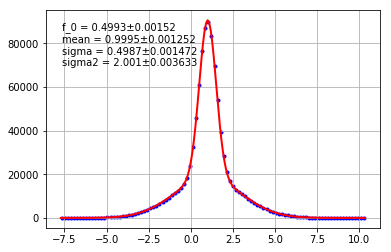

In [31]:
unbinned_lh.draw(minuit);

## CUPY GPU

Let's use CUPY on the GPU:

In [32]:
import cupy

In [33]:
%%time
d_dist = cupy.array(dist)

CPU times: user 129 ms, sys: 27.5 ms, total: 157 ms
Wall time: 141 ms


In [34]:
def gaussian(x, μ, σ):
    return 1/cupy.sqrt(2*np.pi*σ**2) * cupy.exp(-(x-μ)**2/(2*σ**2))

In [35]:
def add(x, f_0, mean, sigma, sigma2):
    return f_0 * gaussian(x, mean, sigma) + (1 - f_0) * gaussian(x, mean, sigma2)

In [36]:
def nll(f_0, mean, sigma, sigma2):
    return -cupy.sum(cupy.log(add(d_dist, f_0, mean, sigma, sigma2)))

In [37]:
mykernel = cupy.ElementwiseKernel(
    'float64 x, float64 f_0, float64 mean, float64 sigma, float64 sigma2',
    'float64 z', '''
    
    double g = 1/sqrt(2*sigma*sigma) * exp(-(x-mean)*(x-mean)/(2*sigma*sigma));
    double g2 = 1/sqrt(2*sigma2*sigma2) * exp(-(x-mean)*(x-mean)/(2*sigma2*sigma2));
    
    double v = f_0 * g + (1 - f_0) * g2;
    
    z = log(v);
    ''', 'mykernel')

In [38]:
def nll2(f_0, mean, sigma, sigma2):
    return -cupy.sum(mykernel(d_dist, f_0, mean, sigma, sigma2))

In [39]:
%%timeit
nll(.5,.5,.5,.5)

773 µs ± 42.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [40]:
%%timeit
nll2(.5,.5,.5,.5)

816 µs ± 564 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [41]:
minuit = Minuit(nll,

                f_0=.5,
                error_f_0=.01,
                limit_f_0=(0,1),
                
                mean=1.5,
                error_mean=.01,
                limit_mean=(-10,10),
                
                sigma=.4,
                limit_sigma=(0,1),
                error_sigma=.01,

                sigma2=3.,
                error_sigma2=.01,
                limit_sigma2=(1,3),
               )

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.


I'm not sure where that errordef warning is coming from.

In [42]:
%%time
output = minuit.migrad()

FCN = 1672890.2007173877 
 TOTAL NCALL = 137 
 NCALLS = 137 
 
 
 EDM = 3.0559267937934915e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,f_0,0.499254,0.00151977,,,0,1,No
1,mean,0.999506,0.0012519,,,-10,10,No
2,sigma,0.498688,0.00147162,,,0,1,No
3,sigma2,2.00066,0.00363329,,,1,3,No


CPU times: user 336 ms, sys: 56 ms, total: 392 ms
Wall time: 391 ms


In [43]:
minuit = Minuit(nll2,

                f_0=.5,
                error_f_0=.01,
                limit_f_0=(0,1),
                
                mean=1.5,
                error_mean=.01,
                limit_mean=(-10,10),
                
                sigma=.4,
                limit_sigma=(0,1),
                error_sigma=.01,

                sigma2=3.,
                error_sigma2=.01,
                limit_sigma2=(1,3),
               )

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:17: InitialParamWarning: errordef is not given. Default to 1.


In [44]:
%%time
output = minuit.migrad()

FCN = 1100525.2577931401 
 TOTAL NCALL = 138 
 NCALLS = 138 
 
 
 EDM = 3.5070106280179944e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,f_0,0.499254,0.00152005,,,0,1,No
1,mean,0.999506,0.0012519,,,-10,10,No
2,sigma,0.498688,0.00147183,,,0,1,No
3,sigma2,2.00066,0.00363381,,,1,3,No


CPU times: user 107 ms, sys: 27 ms, total: 134 ms
Wall time: 133 ms
